using my 'segmentation' virtual environment

brew install graphviz # filas on macos sierra
conda install python-graphviz

In [1]:
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import dask.array as da

import matplotlib.pyplot as plt
%matplotlib inline

import os
from skimage import data, io

In [2]:
path = '/Users/cudmore/box/data/nathan/20200518'

filename_pattern = os.path.join(path, '20200518__A01_G001_*_ch1.tif')

myTile = dask_image.imread.imread(filename_pattern)
print(myTile)

dask.array<concatenate, shape=(48, 64, 512, 512, 3), dtype=uint16, chunksize=(1, 64, 512, 512, 3), chunktype=numpy.ndarray>


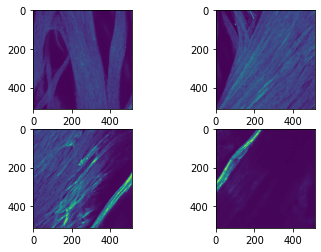

In [3]:
#myTile has 3 color channels as last dimension, just use last dim 0

fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(myTile[0][10,:,:,0])
ax[0,1].imshow(myTile[1][10,:,:,0])
ax[1,0].imshow(myTile[2][10,:,:,0])
ax[1,1].imshow(myTile[3][10,:,:,0])
plt.show()

single image

dask.array<add, shape=(1, 612, 794), dtype=float64, chunksize=(1, 612, 794), chunktype=numpy.ndarray>
Original image dimensions:  (1, 612, 794, 4)
Processed image dimensions: (1, 612, 794)


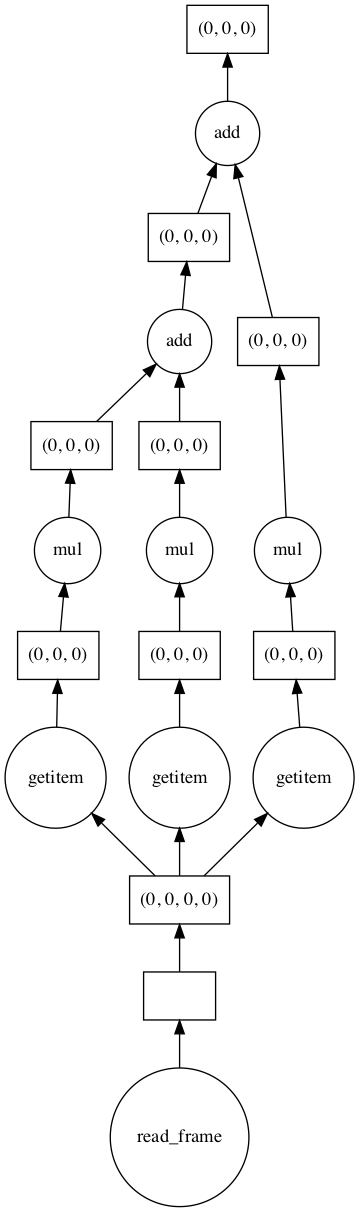

In [4]:
def myGrayscale(rgb):
    result = ((rgb[..., 0] * 0.2125) + 
              (rgb[..., 1] * 0.7154) + 
              (rgb[..., 2] * 0.0721))
    return result

filename = '/Users/cudmore/Desktop/Untitled.png'

astronaut = dask_image.imread.imread(filename)

single_image_result = myGrayscale(astronaut)

print(single_image_result)
print("Original image dimensions: ", astronaut.shape)
print("Processed image dimensions:", single_image_result.shape)

single_image_result.visualize()



multiple images

myTile: (48, 64, 512, 512)
dask.array<add, shape=(48, 64, 512), dtype=float64, chunksize=(1, 64, 512), chunktype=numpy.ndarray>


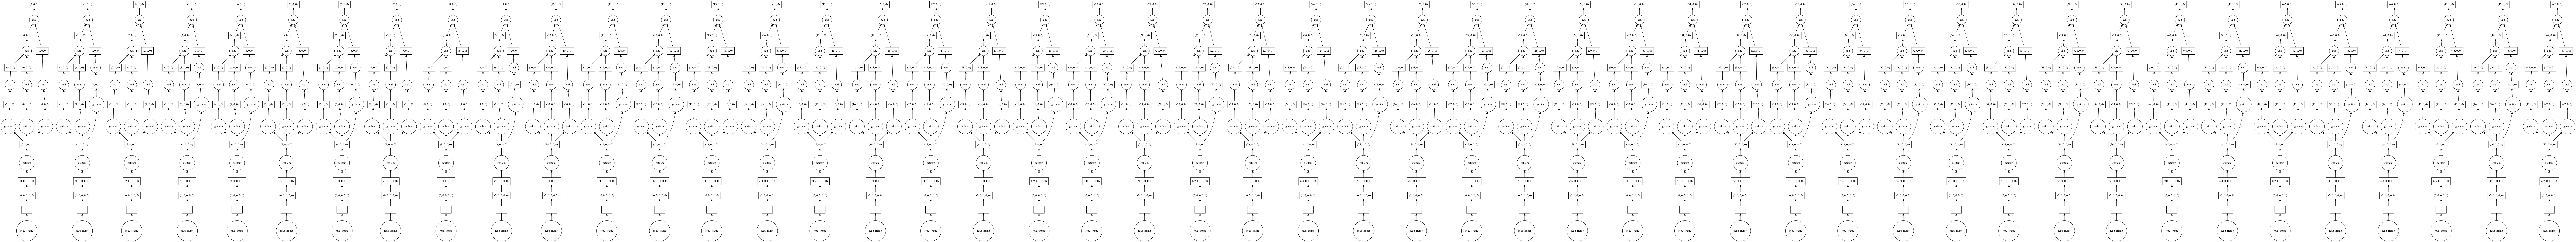

In [5]:
path = '/Users/cudmore/box/data/nathan/20200518'

filename_pattern = os.path.join(path, '20200518__A01_G001_*_ch1.tif')

myTile = dask_image.imread.imread(filename_pattern)
myTile = myTile[..., 0]

print('myTile:', myTile.shape)

result = myGrayscale(myTile) # returns dask.array
print(result)
result.visualize()

In [6]:
myBlock = da.block(myTile)
myBlock

,Array,Chunk
Bytes,1.61 GB,33.55 MB
Shape,"(48, 64, 512, 512)","(1, 64, 512, 512)"
Count,192 Tasks,48 Chunks
Type,uint16,numpy.ndarray


In [7]:
# if i pass a block here, it takes filter of pixels on edge of mage, between different images
#smoothed_image = dask_image.ndfilters.gaussian_filter(myBlock, sigma=[0, 1, 1, 1])
smoothed_image = dask_image.ndfilters.median_filter(myBlock, size=(1,2,3,3))

smoothed_image

,Array,Chunk
Bytes,1.61 GB,33.55 MB
Shape,"(48, 64, 512, 512)","(1, 64, 512, 512)"
Count,432 Tasks,48 Chunks
Type,uint16,numpy.ndarray


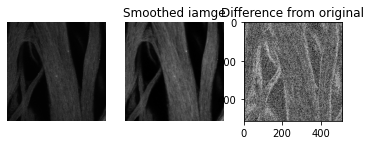

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(myBlock[0,10,...], cmap='gray')
axs[1].imshow(smoothed_image[0,10,...], cmap='gray')
axs[2].imshow(smoothed_image[0,10,...] - myBlock[0,10,...], cmap='gray')

# Subplot headings
axs[1].set_title('Smoothed iamge')
axs[2].set_title('Difference from original')

# Don't display axes
axs[0].axis('off')
axs[1].axis('off')

# Display images
plt.show(fig)

starrt a client

requires:
    conda install dask distributed

In [9]:
'''
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client
'''

"\nfrom dask.distributed import Client, progress\nclient = Client(processes=False, threads_per_worker=4,\n                n_workers=1, memory_limit='2GB')\nclient\n"

dask.array<func, shape=(48, 64, 512, 512), dtype=uint8, chunksize=(1, 64, 512, 512), chunktype=numpy.ndarray>


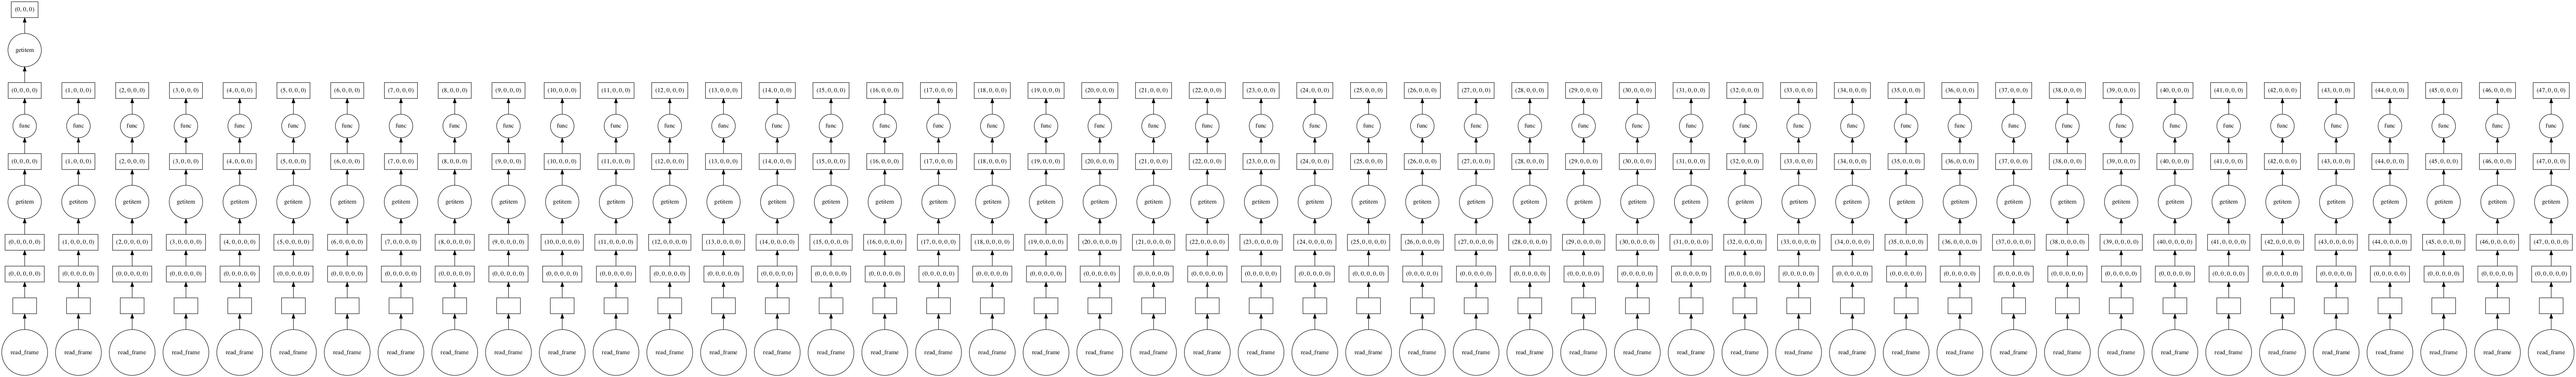

In [10]:
import scipy
from functools import partial

def last3dims(f):
    # this is just a wrapper because the pycudadecon function
    # expects ndims==3 but our blocks will have ndim==4
    def func(array):
        return f(array[0])[None, ...]
    return func


#myMedianFunc = last3dims(partial(dask_image.ndfilters.median_filter, size=(2,3,3)))
myMedianFunc = last3dims(partial(scipy.ndimage.median_filter, size=(2,3,3)))

myMedian = myTile.map_blocks(myMedianFunc, dtype="uint8")

print(myMedian)
myMedian[0,...].visualize()

Run median filter in parallel

48 images finish in 54 sec, if done in series, takes 216 seconds (with 4 cores)

In [11]:
import time
startSeconds = time.time()

medianResults = myMedian.compute()

stopSeconds = time.time()
print('finished in', round(stopSeconds-startSeconds,2), 'seconds')

finished in 48.15 seconds


Do it in series

In [62]:
n = len(myMedian)
for idx, i in enumerate(myMedian):
    if idx > 5:
        break
    print(idx, 'of', n)
    startSeconds = time.time()
    i.compute()
    stopSeconds = time.time()
    print('   finished in', round(stopSeconds-startSeconds,2), 'seconds')

0 of 48
   finished in 4.81 seconds
1 of 48
   finished in 4.75 seconds
2 of 48
   finished in 4.76 seconds
3 of 48
   finished in 4.66 seconds
4 of 48
   finished in 4.25 seconds
5 of 48
   finished in 4.39 seconds
